In [1]:

import sys
from agents import *

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### where path to read & write

notebook_name = "train_CartPole_vanilla"
BASE_DIR = './'
CHECK_POINT_DIR = BASE_DIR+notebook_name
TB_SUMMARY_DIR = CHECK_POINT_DIR+"/tb_summary"

### what env to use ###

import gym
env = gym.make('CartPole-v0')

state_space_size = 0

try:
    state_space_size = env.observation_space.n
except:
    state_space_size = env.observation_space.shape[0]
action_space_size = env.action_space.n

state_size=state_space_size
hidden_size=8
action_size=action_space_size

layers = [state_size, hidden_size, action_size]

# Load the agent.
init_learning_rate = 1e-2
agent = VanillaPolicyGradient(learning_rate=init_learning_rate, discount_factor=0.9,
                              layers=layers,
                              reward_standardize=True
                             ) 


scope: VanillaPolicyGradient learning_rate: 0.01 discount_factor: 0.9 reward_standardize: True


In [2]:
import shutil
try:
    shutil.rmtree(CHECK_POINT_DIR)
    print CHECK_POINT_DIR, "removed"
except:
    print CHECK_POINT_DIR, "does not exists yet"


./train_CartPole_vanilla removed


In [3]:
def print_now():
    import datetime
    from dateutil.tz import tzlocal

    # Get the current date/time with the timezone.
    now = datetime.datetime.now(tzlocal())
    fmt1 = now.strftime('%Y-%m-%d %A %H:%M:%S %Z')

    # Print it out.
    print 'now: %s' % (fmt1)
    
def try_and_error(env, agent, total_episodes,
                  update_frequency, learning_rate_frequency, debug_frequency,
                  is_train = True
                 ):
    total_reward = []
    min_learning_rate = 1e-10
    decay_learning_rate = 0.9
    previous_loss = 9e+10
    last_save_name = ""

    for i in range(total_episodes):
        s = env.reset()
        reward_sum = 0
        
        done = False
        while not done:
            # Run the policy network and get an action to take.
            if is_train == True:
                action = agent.get_action(sess, s)
            else:
                action = agent.exploit(sess, s)
            
            # step the environment and get new measurements
            observation, reward, done, _ = env.step(action)
            reward_sum += reward
            agent.after_action(sess, reward)
            
            s = observation
        
        if is_train == True:
            loss , _ , _ = agent.after_episode(sess)
            # If we have completed enough episodes, then update the policy network with our gradients.
            if i % update_frequency == 0 and i != 0:
                agent.after_batch(sess)

            # decaying learning rate
            if i % learning_rate_frequency == 0 and i != 0:
                if (loss > previous_loss and agent.learning_rate >= min_learning_rate):
                    agent.learning_rate = agent.learning_rate * decay_learning_rate
                    print "i:", i, "new agent.learning_rate", agent.learning_rate
                previous_loss = loss

        total_reward.append(reward_sum)
        
        #Update our running tally of scores.
        if i % debug_frequency == 0:
            print "-------------------------------------------"
            print_now()
            mean = np.mean(total_reward)
            print i, (mean)
            plt_means.append(mean)
            total_reward = []
            if is_train == True and loss <= previous_loss:
                # save only better model
                agent.save_model(sess, CHECK_POINT_DIR)


In [4]:
plt_means=[]
init = tf.global_variables_initializer()

# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)  
    agent.before(sess)
    
    try_and_error(env, agent,
                  total_episodes=1000,
                  update_frequency=3,
                  debug_frequency=100,
                  learning_rate_frequency=50,
                  is_train=True
                 )
    

-------------------------------------------
now: 2017-11-01 Wednesday 17:18:44 KST
0 9.0
Model saved at ./train_CartPole_vanilla
i: 100 new agent.learning_rate 0.009
-------------------------------------------
now: 2017-11-01 Wednesday 17:18:45 KST
100 24.15
Model saved at ./train_CartPole_vanilla
i: 200 new agent.learning_rate 0.0081
-------------------------------------------
now: 2017-11-01 Wednesday 17:18:46 KST
200 30.96
Model saved at ./train_CartPole_vanilla
-------------------------------------------
now: 2017-11-01 Wednesday 17:18:48 KST
300 48.99
Model saved at ./train_CartPole_vanilla
i: 350 new agent.learning_rate 0.00729
i: 400 new agent.learning_rate 0.006561
-------------------------------------------
now: 2017-11-01 Wednesday 17:18:51 KST
400 74.76
Model saved at ./train_CartPole_vanilla
i: 450 new agent.learning_rate 0.0059049
-------------------------------------------
now: 2017-11-01 Wednesday 17:18:54 KST
500 80.78
Model saved at ./train_CartPole_vanilla
i: 550 new 

Means of each bundle of episodes


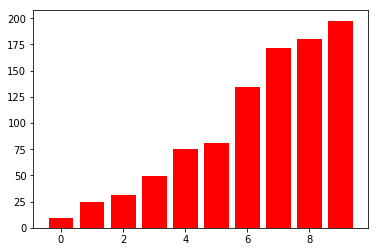

now: 2017-11-01 Wednesday 17:19:27 KST


In [5]:
print("Means of each bundle of episodes")
plt.bar(range(len(plt_means)), plt_means, color="red")
plt.show()
print_now()

In [6]:
########## 기존 모델을 로딩하여 추가로 학습 후 저장하기 ##########

# Launch the tensorflow graph
with tf.Session() as sess:
    
    agent.load_model(sess, CHECK_POINT_DIR)
    
    try_and_error(env, agent,
                  total_episodes=1000,
                  update_frequency=3,
                  debug_frequency=100,
                  learning_rate_frequency=50,
                  is_train=True
                 )
    

print_now()

INFO:tensorflow:Restoring parameters from ./train_CartPole_vanilla/model.ckpt-201711011719
Model restored successfully from ./train_CartPole_vanilla
-------------------------------------------
now: 2017-11-01 Wednesday 17:19:27 KST
0 200.0
Model saved at ./train_CartPole_vanilla
i: 100 new agent.learning_rate 0.00282429536481
-------------------------------------------
now: 2017-11-01 Wednesday 17:19:35 KST
100 199.72
Model saved at ./train_CartPole_vanilla
-------------------------------------------
now: 2017-11-01 Wednesday 17:19:42 KST
200 199.72
Model saved at ./train_CartPole_vanilla
i: 250 new agent.learning_rate 0.00254186582833
i: 300 new agent.learning_rate 0.0022876792455
-------------------------------------------
now: 2017-11-01 Wednesday 17:19:50 KST
300 199.48
Model saved at ./train_CartPole_vanilla
-------------------------------------------
now: 2017-11-01 Wednesday 17:19:57 KST
400 198.5
Model saved at ./train_CartPole_vanilla
i: 450 new agent.learning_rate 0.002058911

In [7]:
########## 기존 모델을 이용하기만 해보기 ##########

# Launch the tensorflow graph
with tf.Session() as sess:
    agent.load_model(sess, CHECK_POINT_DIR)
    agent.before(sess)
    
    try_and_error(env, agent,
                  total_episodes=1000,
                  update_frequency=3,
                  debug_frequency=100,
                  learning_rate_frequency=50,
                  is_train=False
                 )

INFO:tensorflow:Restoring parameters from ./train_CartPole_vanilla/model.ckpt-201711011720
Model restored successfully from ./train_CartPole_vanilla
-------------------------------------------
now: 2017-11-01 Wednesday 17:20:41 KST
0 200.0
-------------------------------------------
now: 2017-11-01 Wednesday 17:20:47 KST
100 200.0
-------------------------------------------
now: 2017-11-01 Wednesday 17:20:53 KST
200 200.0
-------------------------------------------
now: 2017-11-01 Wednesday 17:20:58 KST
300 200.0
-------------------------------------------
now: 2017-11-01 Wednesday 17:21:04 KST
400 200.0
-------------------------------------------
now: 2017-11-01 Wednesday 17:21:10 KST
500 200.0
-------------------------------------------
now: 2017-11-01 Wednesday 17:21:15 KST
600 200.0
-------------------------------------------
now: 2017-11-01 Wednesday 17:21:21 KST
700 200.0
-------------------------------------------
now: 2017-11-01 Wednesday 17:21:27 KST
800 200.0
----------------

Means of each bundle of episodes


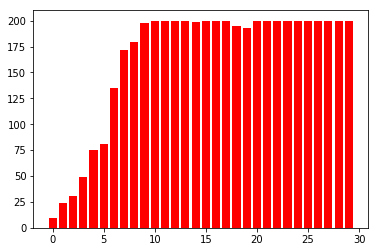

now: 2017-11-01 Wednesday 17:21:38 KST


In [8]:
print("Means of each bundle of episodes")
plt.bar(range(len(plt_means)), plt_means, color="red")
plt.show()
print_now()

In [9]:
sorted(agent.read_ckpt(CHECK_POINT_DIR))

['VanillaPolicyGradient/VanillaPolicyGradient/fully_connected/weights/Adam',
 'VanillaPolicyGradient/VanillaPolicyGradient/fully_connected/weights/Adam_1',
 'VanillaPolicyGradient/VanillaPolicyGradient/fully_connected_1/weights/Adam',
 'VanillaPolicyGradient/VanillaPolicyGradient/fully_connected_1/weights/Adam_1',
 'VanillaPolicyGradient/fully_connected/weights',
 'VanillaPolicyGradient/fully_connected_1/weights',
 'VanillaPolicyGradient_1/beta1_power',
 'VanillaPolicyGradient_1/beta2_power']